# Streaming Anomaly Detection for the Cod-RNA dataset

H. Huang and S. Kasiviswanathan, "**Streaming Anomaly Detection Using Randomized Matrix Sketching**," http://bit.ly/1FaDw6S.

In [1]:
import numpy as np
import numpy.linalg as ln
import pandas as pd
import sklearn.metrics as met

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

from anom_detect import AnomDetect

## Data preparation

CodRNA dataset is available: https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html

In [3]:
def read_CodRNA(path):
    """
    Read Cod-RNA dataset with given path
    Data format:
        label 1:xxx 2:xxx 3:xxx ... 8:xxx
    """
    X = []
    y = []

    with open(path) as f:
        lines = f.readlines()
        for line in lines:
            l = line.rstrip().split(' ')
            y.append(int(l[0]))
            x = []
            for i in range(1, 9): # 8 features in total
                x.append(float(l[i][2:]))
            X.append(x)
    
    return np.asarray(X).T, np.asarray(y)

# read all Cod-RNA dataset and merge them
X_train, y_train = read_CodRNA('../../data/cod-rna/cod-rna.train')
X_valid, y_valid = read_CodRNA('../../data/cod-rna/cod-rna.valid')
X_unused, y_unused = read_CodRNA('../../data/cod-rna/cod-rna.unused')

X = np.hstack((X_train, X_valid, X_unused))
y = np.hstack((y_train, y_valid, y_unused))

X.shape, y.shape

((8, 488565), (488565,))

In [4]:
# number of anomalies; 33.33% of 488565 samples
np.where(y == 1)[0].size / float(y.size)

0.3333333333333333

In [5]:
# training data is randomly sampled 2000 non-anomalies (label=-1)
all_good_idx = np.where(y == -1)[0]
np.random.shuffle(all_good_idx)
Y0 = X[:, all_good_idx[:2000]]
Y0.shape

(8, 2000)

## Anomaly detection

In [6]:
# initialize and train anomaly detector
# percentage of anomalies (0.33) is given as a prior knowledge
detector = AnomDetect(Y0, criterion='p', criterion_v=0.33)

In [7]:
# generate all test indices, and omit indices of training samples
all_idx = np.array(xrange(y.size))
idx = np.setdiff1d(all_idx, all_good_idx[:2000])
np.random.shuffle(idx)
n_idx = idx.size # 488565 - 2000
n_idx

486565

In [8]:
# draw ROC curve for various thresholds

TPRs = []
FPRs = []

# try 20 different thresholds
for n in range(20):
    th = n * .02
    
    # train randomly sampled 2000 normal samples
    detector = AnomDetect(Y0, criterion='th', criterion_v=th)

    # test 5000 samples ramdomly picked from non-train samples
    all_idx = np.array(xrange(y.size))
    idx = np.setdiff1d(all_idx, all_good_idx[:2000])
    np.random.shuffle(idx)
    anomaly_idx, non_anomaly_idx = detector.detect(X[:, idx[:5000]])

    y_this_step = y[idx[:5000]]
    TP = np.where(y_this_step[anomaly_idx] == 1)[0].size
    FP = np.where(y_this_step[anomaly_idx] == -1)[0].size
    TN = np.where(y_this_step[non_anomaly_idx] == -1)[0].size
    FN = np.where(y_this_step[non_anomaly_idx] == 1)[0].size

    FPR = FP / float(TN + FP)
    FPRs.append(FPR)

    TPR = TP / float(TP + FN)
    TPRs.append(TPR)

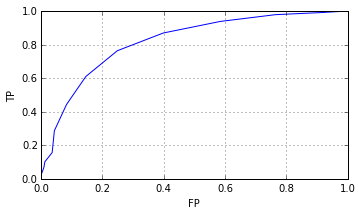

In [9]:
# plot the result

fig, ax = plt.subplots()
ax.plot(FPRs, TPRs)
ax.set_xlabel('FP')
ax.set_ylabel('TP')
ax.grid(True)
fig.set_size_inches((5.5,3))
fig.patch.set_alpha(0.0)